In [138]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import time
import datetime
import nltk
import re

In [139]:
# hyperparameters
batch_size = 128
block_size = 32  # spatial extent of the model for its context
max_iters = 5000  # number of training iterations
eval_interval = 10  # frequency of printing training stats
learning_rate = 3e-4
device = torch.device('mps')
eval_iters = 200  # number of iterations to evaluate the model
n_embd = 600 
n_layers = 6
dropout = 0.2
n_head = 6
data_filepath = 'combined.txt'
train_val_split = 0.95

In [140]:

def tokenize(text):
    # Use regular expression to tokenize the text
    tokens = re.findall(r'\b\w+\b|\s|\S', text)
    return tokens

# Load data
with open(data_filepath, 'r', encoding='utf-8') as f:
    text = f.read()

# Tokenize into words
words = tokenize(text) # list of words
vocab = list(set(words))
vocab_size = len(vocab)
print(f' - Number of words: {len(words):,}')
print(vocab[:50])
print(f' - Vocabulary size: {vocab_size:,}')
stoi = {word: i for i, word in enumerate(vocab)}  # string to int
itos = {i: word for i, word in enumerate(vocab)}  # int to string


def encode(s): return [stoi[word] for word in s]
def decode(l): return ' '.join([itos[i] for i in l])


# Split into train and validation
data = torch.tensor(encode(words), dtype=torch.long)
n = int(train_val_split * len(data))
train_data = data[:n]
val_data = data[n:]
print(f' - Length of train data: {len(train_data):,}')
print(f' - Length of val data: {len(val_data):,}')


def get_batch(split, batch_size, block_size):
    """
    Get a batch of data for training or validation.

    Parameters:
    split (str): The split to get the data from. Can be 'train' or 'val'.
    batch_size (int): The batch size.
    block_size (int): The sequence length.

    Returns:
    torch.Tensor, torch.Tensor: The input data (x) and target data (y) as tensors.
    """

    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i: i + block_size] for i in ix])
    y = torch.stack([data[i + 1: i + block_size + 1] for i in ix])
    return x, y






 - Number of words: 2,622,431
['murky', 'Replaced', 'Guidelines', 'Finite', 'Hullo', 'Bits', 'tie', 'resplendent', 'adept', 'Doxys', 'Fisheries', 'Father', 'sputtered', 'aquired', 'mammal', 'Snout', 'mounts', 'recipes', 'Slither', 'durable', 'damaged', 'delegations', 'leaves', 'crude', 'Than', 'tyke', 'Cries', 'cos', 'messages', 'staked', 'blizzard', 'fancies', 'service', 'treatment', 'Bugbear', 'advances', 'reserved', 'waltz', 'mornIng', 'Branstone', 'punishing', 'scrubs', 'tad', 'tense', 'Delighted', 'curly', 'amulets', 'flippers', 'springily', 'stricken']
 - Vocabulary size: 26,960
 - Length of train data: 2,491,309
 - Length of val data: 131,122


In [141]:

class Transformer(nn.Module):
    ''' A transformer language model. Parameters are defined in the hyperparameters section and do not need to be passed in.
    The class has two methods: forward and generate. Forward is used for training and generate is used for sampling.
    In the forward method, the input is a batch of sequences of tokens, and optionally a batch of target sequences of tokens.'''

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(
            *[Block(n_embd, n_layers) for _ in range(n_layers)]
        )
        self.final_ln = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        ''' idx is a batch of sequences of tokens. targets is a batch of target sequences of tokens. If targets is None, then the loss is not calculated.'''
        B, T = idx.shape
        # idx and targets are both (B,T) tensors. where B is batch size and T is the number of tokens in each sequence (block_size*batch_size)

        tok_emb = self.token_embedding_table(idx)  # (B,T,C)
        pos_emb = self.position_embedding_table(
            torch.arange(T, device=device))  # (T,C)
        x = tok_emb + pos_emb  # (B,T,C)
        x = self.blocks(x)  # (B,T,C)
        x = self.final_ln(x)  # (B,T,C)
        logits = self.lm_head(x)  # (B,T,V)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        ''' idx is a batch of sequences of tokens. max_new_tokens is the maximum number of tokens to generate.
        returns both the whole sequence as well as the last generated token, for live generation.'''
        for _ in range(max_new_tokens):
            # crop idx
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=-1)
        return idx, idx_next


class Head(nn.Module):
    '''a single self attention head'''

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(
            torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)  # (B,T,C)
        q = self.query(x)  # (B,T,C)
        wei = q @ k.transpose(-2, -1) * (C ** -0.5)  # (B,T,T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)  # (B,T,T)
        wei = self.dropout(wei)
        v = self.value(x)  # (B,T,C)
        out = wei @ v  # (B,T,C)
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(n_heads)])
        # Q. what is proj an abbreviation for? A. projection Q. What is meant by projection? A. I think it means that the output is the same size as the input.3
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)  # (B,T,C)
        out = self.proj(out)
        out = self.dropout(out)
        return out


class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class LayerNorm(nn.Module):

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        # calculate the forward pass

        xmean = x.mean(1, keepdim=True)  # batch mean
        xvar = x.var(1, keepdim=True)  # batch variance

        # normalize to unit variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [142]:
m = Transformer().to(device)
m.generate(torch.randint(vocab_size, (1, 1), device=device), 100)
# Training loop
optimizer = torch.optim.Adam(m.parameters(), lr=learning_rate)
lossi = []  # loss history
current_step = 0
print(f'Model is running on {device}')
print(f'Number of parameters: {sum(p.numel() for p in m.parameters()):,}')

Model is running on mps
Number of parameters: 58,355,360


In [195]:


start_time = time.time()
current_step_this_run = 0
while current_step < max_iters:
    xb, yb = get_batch('train', batch_size, block_size)
    xb, yb = xb.to(device), yb.to(device)
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    lossi.append(loss.item())

    # Print training stats
    if current_step % eval_interval == 0 or current_step == max_iters - 1:
        current_time = round(time.time() - start_time)
        formatted_time = str(datetime.timedelta(seconds=round(current_time,2)))
        
        # Estimate remaining time
        steps_remaining = max_iters - current_step
        time_per_step = current_time / (current_step_this_run + 1)  # Avoid division by zero
        remaining_time = datetime.timedelta(
        
            seconds=round(steps_remaining * time_per_step))
        if current_step == 0:
            average_loss = loss.item()
        else:
            average_loss = sum(lossi[-eval_interval:]) / eval_interval # This is not correct, it should be the average loss over the last eval_interval steps
        

        
        
        print(f'step: {current_step}/{max_iters}|||average loss over last {eval_interval} steps: {round(average_loss,5)}|||time taken: {formatted_time}|||estimated time remaining: {remaining_time} \n')
    current_step += 1
    current_step_this_run += 1

# Print the total training time
total_time = time.time() - start_time
formatted_total_time = str(datetime.timedelta(seconds=total_time))
print(f'Total training time: {formatted_total_time}')

step: 1280/5000|||average loss over last 10 steps: 2.45165|||time taken: 0:00:20|||estimated time remaining: 2:57:09 

step: 1290/5000|||average loss over last 10 steps: 2.45472|||time taken: 0:00:42|||estimated time remaining: 2:32:46 

step: 1300/5000|||average loss over last 10 steps: 2.43687|||time taken: 0:01:05|||estimated time remaining: 2:28:27 

step: 1310/5000|||average loss over last 10 steps: 2.44756|||time taken: 0:01:33|||estimated time remaining: 2:34:35 

step: 1320/5000|||average loss over last 10 steps: 2.44333|||time taken: 0:01:57|||estimated time remaining: 2:32:41 

step: 1330/5000|||average loss over last 10 steps: 2.42834|||time taken: 0:02:17|||estimated time remaining: 2:27:01 

step: 1340/5000|||average loss over last 10 steps: 2.44998|||time taken: 0:02:42|||estimated time remaining: 2:27:30 

step: 1350/5000|||average loss over last 10 steps: 2.43788|||time taken: 0:03:09|||estimated time remaining: 2:29:19 



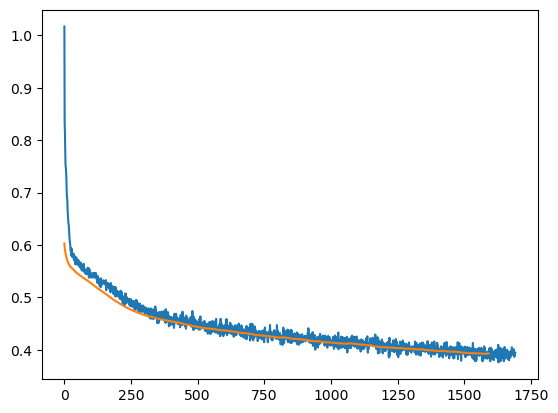

In [191]:
# Plot loss history
import numpy as np

plt.plot(np.log10(lossi))
lossi_means = [sum(lossi[i:i+100])/100 for i in range(len(lossi)-100)]
plt.plot(np.log10(lossi_means))
plt.show()

In [193]:
# Evaluation loop over validation set

with torch.no_grad():
    total_loss = 0
    for steps in range(20):
        xb, yb = get_batch('val', batch_size, block_size)
        xb, yb = xb.to(device), yb.to(device)
        logits, loss = m(xb, yb)
        total_loss += loss.item()
    print(f'validation loss: {total_loss/eval_iters}')

validation loss: 0.2517848265171051


In [194]:
# Generate from the model, printing the output as it goes
new_chars = 10000
idx = torch.zeros((1, 1), dtype=torch.long).to(device)
with torch.no_grad():
    for _ in range(new_chars):
        _,output = m.generate(idx, 1)
        decoded_output = decode([output.item()])
        print(decoded_output, end = '') 
        idx = torch.cat((idx, output), dim=-1)
        

 him spoke to with deal, but walked from his second and more gray inside. 'You come off here, which is our schools,' said Sirius warningly, watching you all over your getting powers and hear the kitchen at all, "waved you Oh, Harry, too!
"mis"."
"Aguamenti --Ron - will come back in to touch Nearly Headless guests!" Black shrieked angrily, ignoring but scooped on Harry with great bearable of scales. "Elphias he owned me these at an excuse our broom, then I'stretched out of the Chamber when I fangs Hogwarts, so 
it crashed my wig might have old some-much creature. And or abroad they have been fifty hard at dinnertime - 
Considered score Christmas!” 

“Harry didn’t help most that unless Dumbledore don’t see Charlie!” said Ron excitedly, and Harry looked around at another wall and felt a dead of light on the wall as Mrs Figg at the hole wheeled along in week, Rookwood. He
younger impossible to die, at least for Horcruxes. . . or Firenze kept having friends kept on it when he was injured, b

KeyboardInterrupt: 

In [98]:
idx = torch.zeros((1, 1), dtype=torch.long).to(device)
output = m.generate(idx, 200)[0].tolist()

decoded_output = decode(output[0])
print(decoded_output)


KeyboardInterrupt: 